In [1]:
print("aaaa")

aaaa


# Collecte

In [32]:
import sys
from SPARQLWrapper import SPARQLWrapper, JSON
from pandas import json_normalize
import pandas as pd
import json

endpoint_url = "https://query.wikidata.org/sparql"
nb_images= "5"

# Get cities
query = """SELECT DISTINCT ?grandeville ?grandevilleLabel ?pays ?paysLabel ?image {
  ?grandeville wdt:P31 wd:Q1549591;
               wdt:P17 ?pays;
               wdt:P18 ?image.
 SERVICE wikibase:label { bd:serviceParam wikibase:language "fr". }
}
LIMIT """+nb_images


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (
        sys.version_info[0],
        sys.version_info[1],
    )
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


array = []
results = get_results(endpoint_url, query)

for index, result in enumerate(results["results"]["bindings"], start=1):
    url = result["image"]["value"]
    urlSplit = url.split('/')
    imageName = urlSplit[-1]

    # Créer un dictionnaire avec les clés et les valeurs correspondantes
    dictionnaire = {
        "id": index,
        "ville": result["grandevilleLabel"]["value"],
        "pays": result["paysLabel"]["value"],
        "url": url,
        "path":"./images/"+imageName
    }
    # Ajouter le dictionnaire à la liste 'array'
    array.append(dictionnaire)


dataframe = pd.DataFrame(array)
dataframe = dataframe.astype(
    dtype={"id": "int32", "ville": "<U200", "pays": "<U200", "url": "<U200"}
)
dataframe
# Écrire les données dans un fichier JSON
with open('./data/data.json', 'w', encoding='utf-8') as f:
    json.dump(array, f, ensure_ascii=False, indent=4)


In [33]:
import requests
import shutil
import os


def download_image(url, destination_path):

    headers = {"User-Agent": "Mozilla/5.0"}
    request = requests.get(url, allow_redirects=True, headers=headers, stream=True)
    if request.status_code == 200:
        with open(destination_path+os.path.basename(url), "wb") as image:
            request.raw.decode_content = True
            shutil.copyfileobj(request.raw, image)
    return request.status_code

destination_path = "./images/"
dataframe.url.apply(lambda x: download_image(x, destination_path))

0    200
1    200
2    200
3    200
4    200
Name: url, dtype: int64

# Couleur prédominante

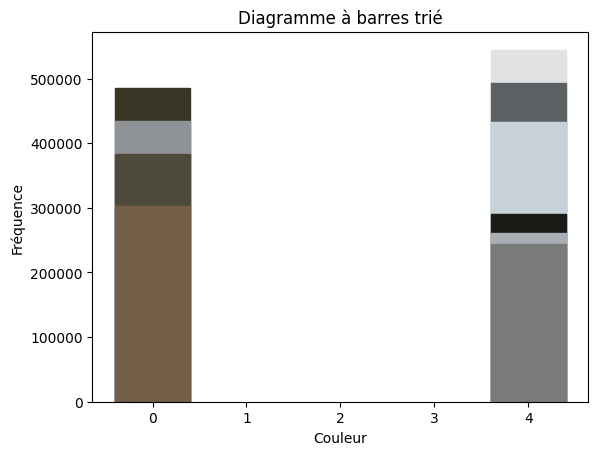

[544759, 492981, 485717, 433898, 432782, 384094, 302740, 289945, 261071, 243501]
[0 1 2 3 4 5 6 7 8 9]
(197, 208, 217)
lightgray
(76, 73, 58)
darkslategray
(56, 53, 36)
darkslategray
(142, 145, 149)
lightslategray
(121, 121, 121)
gray
(224, 225, 225)
gainsboro
(91, 97, 99)
dimgray
(25, 26, 21)
black
(168, 174, 179)
darkgray
(114, 94, 70)
dimgray


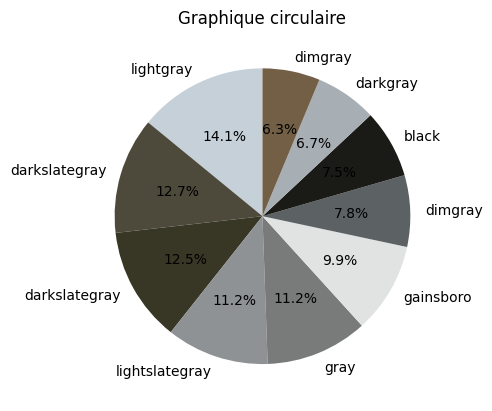

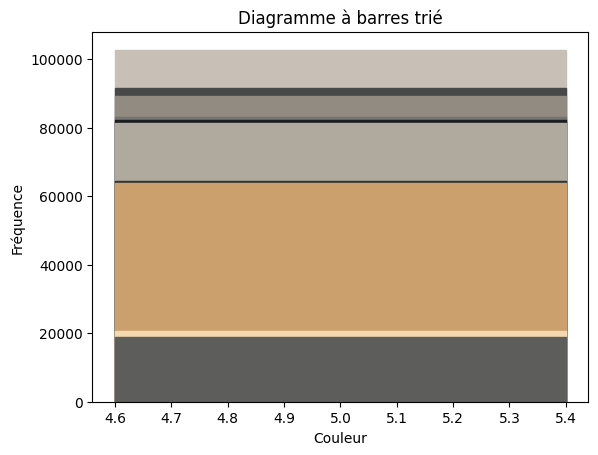

[102767, 91486, 89244, 83219, 82276, 81338, 64361, 63990, 20746, 18941]
[0 1 2 3 4 5 6 7 8 9]
(199, 191, 182)
silver
(48, 51, 51)
darkslategray
(69, 72, 71)
darkslategray
(25, 29, 31)
black
(115, 116, 111)
dimgray
(92, 93, 90)
dimgray
(175, 168, 156)
darkgray
(144, 138, 128)
gray
(243, 215, 175)
wheat
(203, 159, 107)
darkkhaki


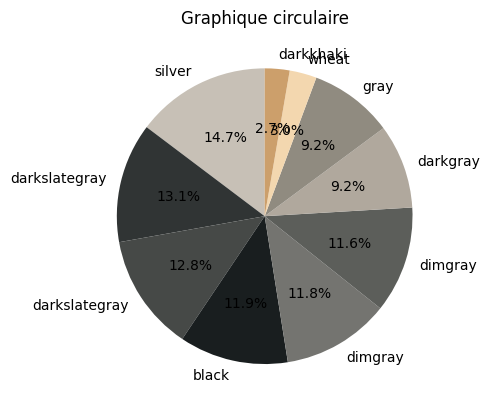

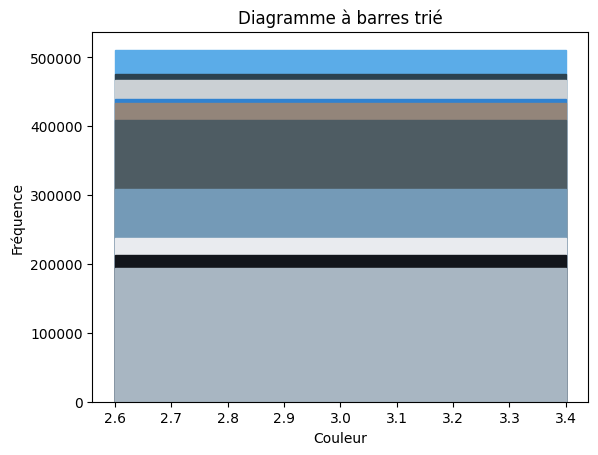

[511144, 476256, 466611, 439123, 433587, 409254, 309094, 238026, 212726, 193459]
[0 1 2 3 4 5 6 7 8 9]
(77, 91, 98)
dimgray
(42, 64, 78)
darkslategray
(90, 171, 231)
cornflowerblue
(47, 129, 207)
royalblue
(167, 181, 193)
silver
(202, 207, 211)
lightgray
(232, 234, 238)
lavender
(17, 20, 26)
black
(115, 153, 182)
cadetblue
(146, 132, 121)
gray


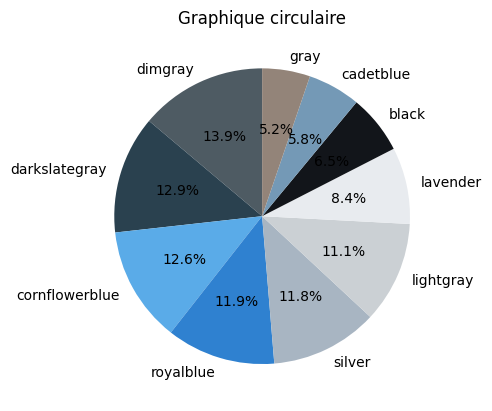

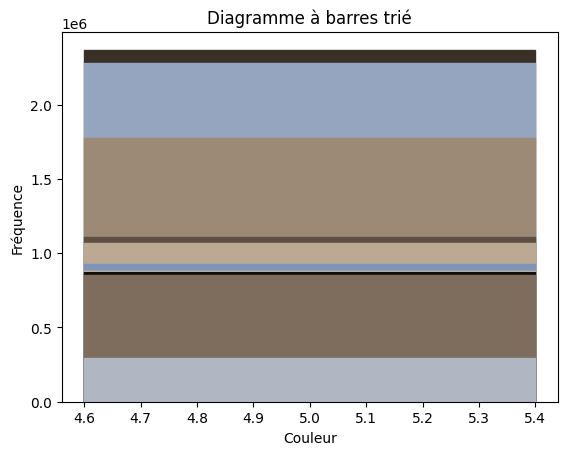

[2368950, 2279598, 1776783, 1111521, 1069207, 927672, 877561, 873557, 852515, 291572]
[0 1 2 3 4 5 6 7 8 9]
(148, 164, 190)
darkgray
(176, 181, 194)
silver
(126, 147, 181)
lightslategray
(125, 108, 91)
dimgray
(155, 137, 118)
gray
(92, 78, 65)
darkolivegreen
(56, 47, 38)
darkslategray
(186, 168, 146)
rosybrown
(18, 13, 10)
black
(226, 209, 182)
wheat


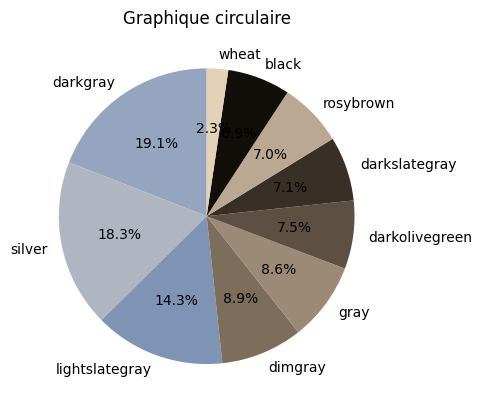

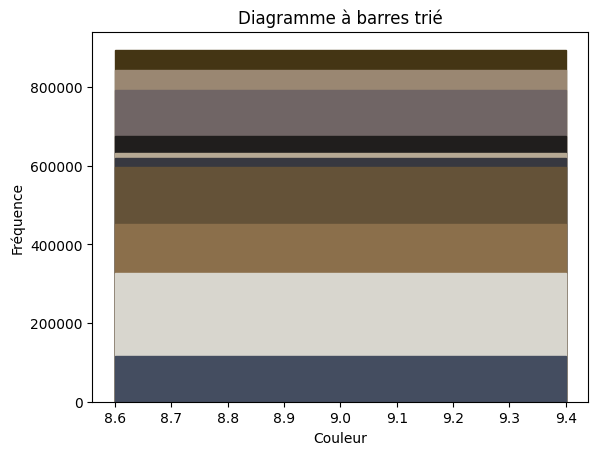

[894573, 841788, 791101, 675143, 632667, 618573, 597639, 451237, 328122, 116549]
[0 1 2 3 4 5 6 7 8 9]
(54, 55, 63)
darkslategray
(67, 76, 95)
darkslategray
(99, 81, 55)
darkolivegreen
(111, 100, 100)
dimgray
(153, 134, 113)
gray
(67, 52, 19)
darkolivegreen
(138, 110, 74)
dimgray
(31, 29, 28)
black
(181, 168, 147)
darkgray
(215, 213, 205)
lightgray


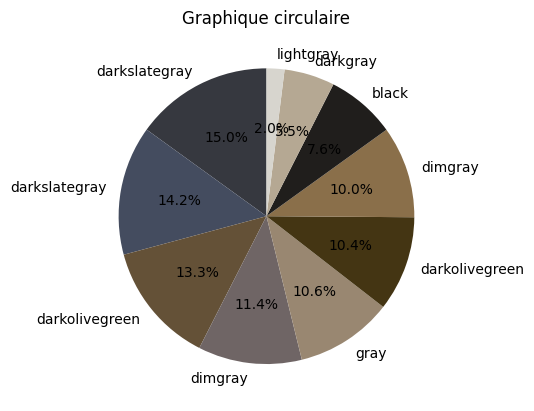

In [52]:
from PIL import Image, ImageColor
import numpy
import math
import matplotlib.pyplot as plot
from sklearn.cluster import KMeans
from webcolors import CSS3_HEX_TO_NAMES, CSS3_NAMES_TO_HEX, rgb_to_name, hex_to_rgb, hex_to_name, rgb_to_hex
from colorspacious import cspace_convert
from PIL.ExifTags import TAGS

def get_approx_color(hex_color):
    orig = hex_to_rgb(hex_color)
    similarity = {}
    for hex_code, color_name in CSS3_HEX_TO_NAMES.items():
        approx = hex_to_rgb(hex_code)
        similarity[color_name] = sum(numpy.subtract(orig, approx) ** 2)
    return min(similarity, key=similarity.get)
 
def get_color_name(hex_color):
    try:
        return hex_to_name(hex_color)
    except ValueError:
        return get_approx_color(hex_color)
    
def determine_image_size(height, width):
    size = height * width
    if size < 5000:
        return "Vignette"
    elif 5000 <= size < 100000:
        return "Petite image"
    elif 100000 <= size < 500000:
        return "Image de taille moyenne"
    else:
        return "Grande image"

#appel json 
# parcours de json
# Demander à l'utilisateur le nombre de clusters et le nom du fichier image
num_clusters = 10
# Lire le fichier JSON
with open('./data/data.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
    # Itérer sur chacun des objets dans le fichier JSON
    for objet in data:
        filename = objet["path"]
        # Charger l'image et la convertir en tableau numpy
        imgfile = Image.open(filename)
        numarray = numpy.array(imgfile.getdata(), numpy.uint8)
        exif_data = imgfile._getexif()

        if exif_data:  # s'il existe des informations EXIF
            for tag, value in exif_data.items():
                if tag in TAGS :
                    if TAGS[tag]=="ExifImageWidth" or TAGS[tag]=="ImageWidth":
                        objet["width"]=value
                    if TAGS[tag]=="ExifImageHeight" or TAGS[tag]=="ImageLength" :
                        objet["height"]=value
                    if TAGS[tag]=="DateTime":
                        date = value
                        dateSplit = date.split(':')
                        year = dateSplit[0]
                        objet["year"] = year
              
        if objet.get("width") is not None and objet.get("height") is not None:
            objet["size"]= determine_image_size(objet["height"], objet["width"])
            if objet["width"] > objet["height"]:
                objet["orientation"]="landscape"
            else:
                objet["orientation"]="portrait"

        


           
        # Regrouper les couleurs en clusters
        clusters = KMeans(n_clusters=num_clusters, n_init=2)
        clusters.fit(numarray)

        # Calculer l'histogramme des étiquettes de cluster triées
        npbins = numpy.arange(0, num_clusters+1)
        histogram, bin_edges = numpy.histogram(clusters.labels_, bins=npbins)
        sort_indices = numpy.argsort(histogram)[::-1]
        histogram_sorted = histogram[sort_indices]
        labels_sorted = clusters.labels_[clusters.labels_ != -1][sort_indices]

        # Créer le diagramme à barres trié
        barlist = plot.bar(labels_sorted, histogram_sorted)
        for i in range(num_clusters):
            barlist[i].set_color(
                "#%02x%02x%02x"
                % (
                    math.ceil(clusters.cluster_centers_[i][0]),
                    math.ceil(clusters.cluster_centers_[i][1]),
                    math.ceil(clusters.cluster_centers_[i][2]),
                ))
        plot.title("Diagramme à barres trié")
        plot.xlabel("Couleur")
        plot.ylabel("Fréquence")
        plot.show()

        # Créer le graphique circulaire
        freqs = [histogram_sorted[i] for i in range(num_clusters)]
        colors = [(c[0]/255, c[1]/255, c[2]/255) for c in clusters.cluster_centers_[sort_indices]]
        labels = labels = numpy.unique(clusters.labels_)
        print(freqs)
        print(labels)
        labels_final = []

        for i in colors:
            r= int(i[0]*255)
            g= int(i[1]*255)
            b= int(i[2]*255)
            print( (r, g, b) , end = '\n')

            hex = rgb_to_hex((round(i[0]*255), round(i[1]*255), round(i[2]*255)))
            color_name = get_color_name(hex)

            print(color_name)
            labels_final.append(color_name)
        plot.pie(freqs, labels=labels_final, colors=colors, startangle=90, autopct='%1.1f%%')
        plot.title("Graphique circulaire")
        plot.show()
        objet["colors"]=list(set(labels_final))

with open('./data/data.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

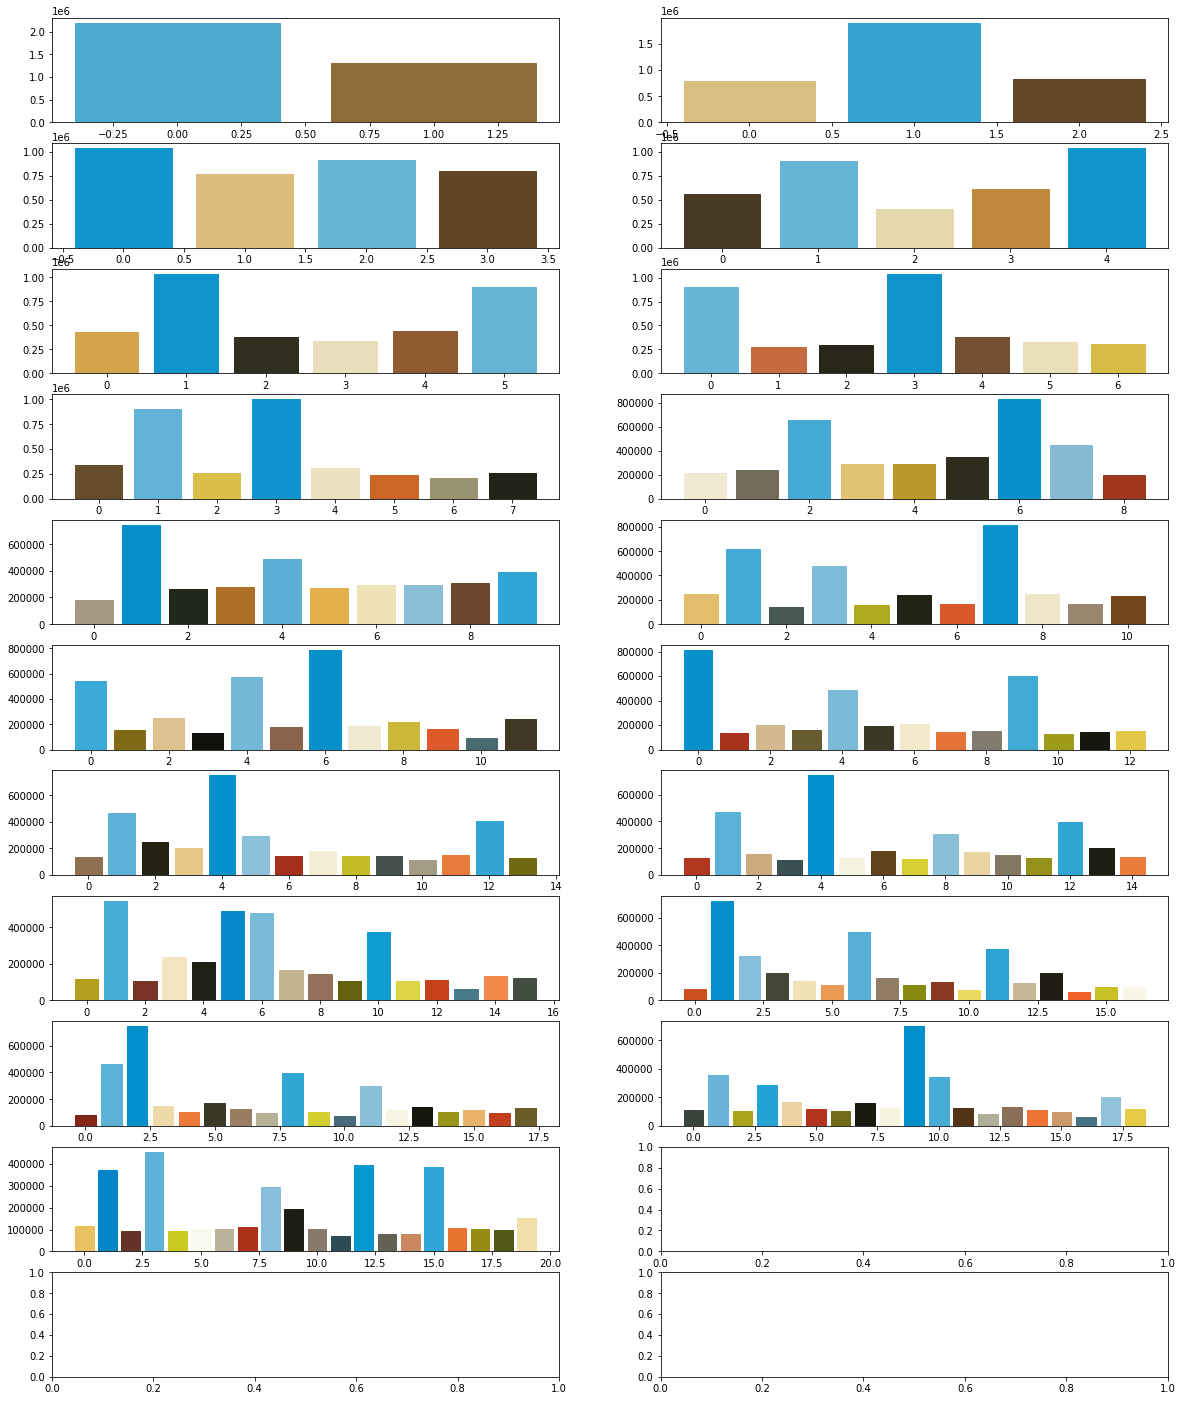

In [8]:
from PIL import Image
import numpy
import math
import matplotlib.pyplot as plot
from sklearn.cluster import MiniBatchKMeans

imgfile = Image.open("./images/Saint-Basil-Red-Square.jpg")
numarray = numpy.array(imgfile.getdata(), numpy.uint8)
X = []
Y = []
fig, axes = plot.subplots(nrows=11, ncols=2, figsize=(20, 25))
xaxis = 0
yaxis = 0
for x in range(2, 21):
    cluster_count = x

    clusters = MiniBatchKMeans(n_clusters=cluster_count, n_init=2)
    clusters.fit(numarray)

    npbins = numpy.arange(0, cluster_count + 1)
    histogram = numpy.histogram(clusters.labels_, bins=npbins)
    labels = numpy.unique(clusters.labels_)
    barlist = axes[xaxis, yaxis].bar(labels, histogram[0])
    if yaxis == 0:
        yaxis = 1
    else:
        xaxis = xaxis + 1
        yaxis = 0
    for i in range(cluster_count):
        barlist[i].set_color(
            "#%02x%02x%02x"
            % (
                math.ceil(clusters.cluster_centers_[i][0]),
                math.ceil(clusters.cluster_centers_[i][1]),
                math.ceil(clusters.cluster_centers_[i][2]),
            )
        )
plot.show()

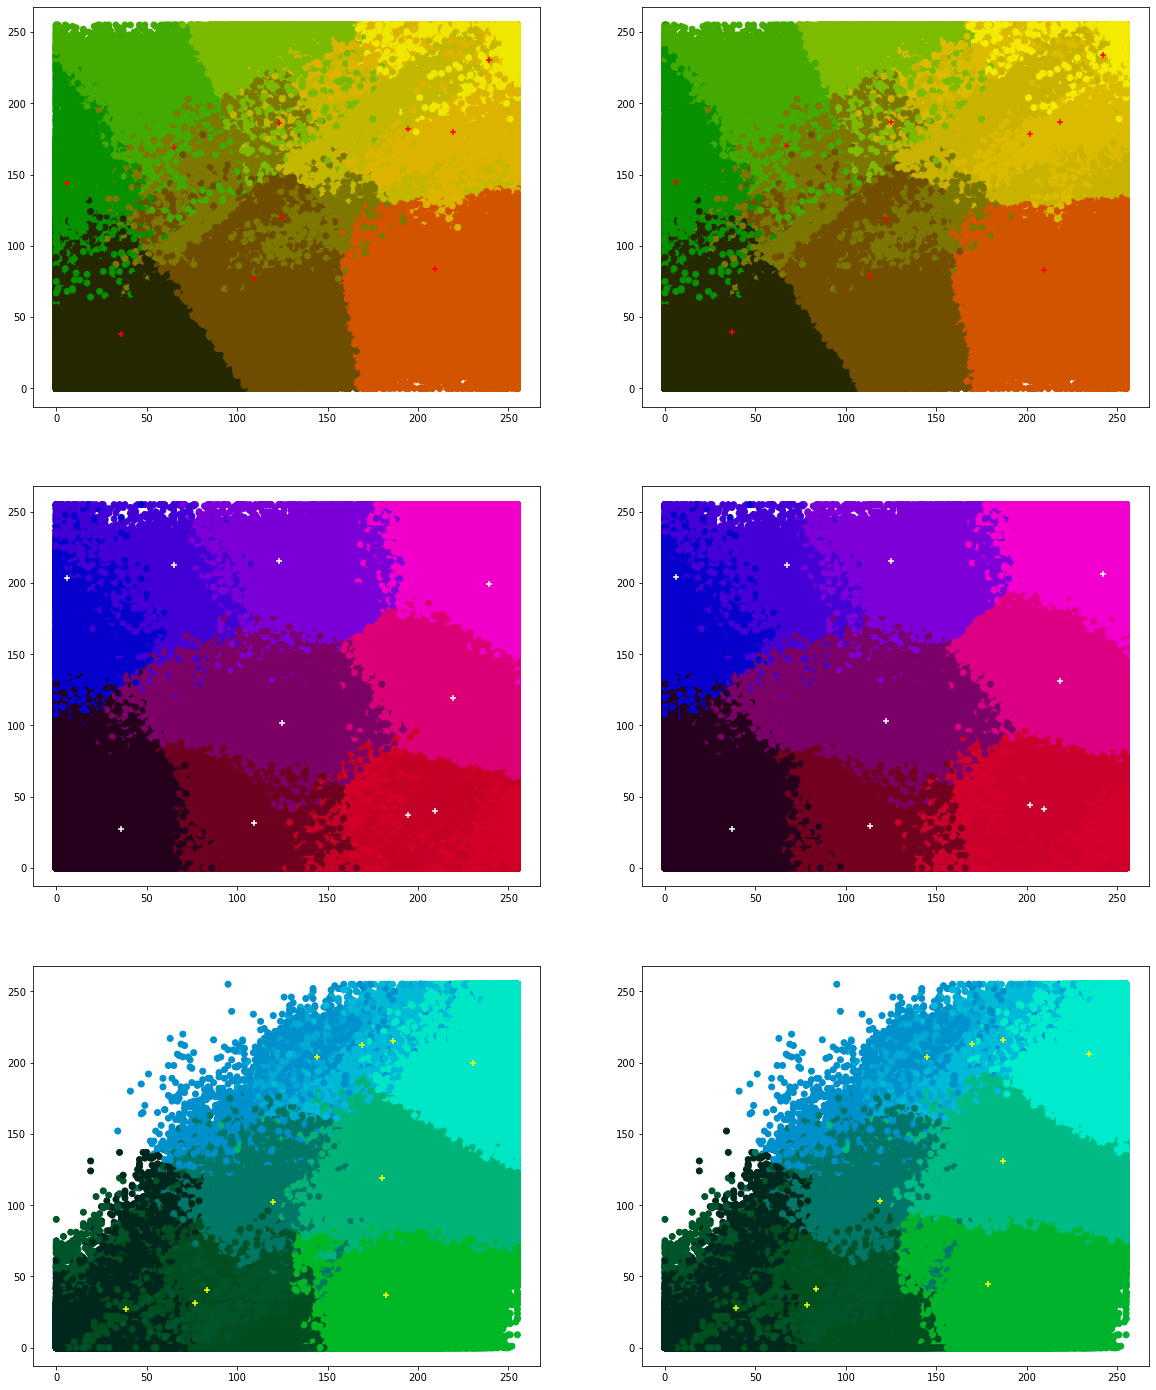

In [6]:
from PIL import Image
import numpy
import math
import time
import matplotlib.pyplot as plot
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

imgfile = Image.open("./images/Saint-Basil-Red-Square.jpg")
numarray = numpy.array(imgfile.getdata(), numpy.uint8)

cluster_count = 10

#MiniBatchKMeans

mclusters = MiniBatchKMeans(n_clusters=cluster_count, n_init=2)
mclusters.fit(numarray)

npbins = numpy.arange(0, cluster_count + 1)
histogram = numpy.histogram(mclusters.labels_, bins=npbins)
labels = numpy.unique(mclusters.labels_)

fig, axes = plot.subplots(nrows=3, ncols=2, figsize=(20, 25))

# Scatter plot for RG (RGB)
colors = []
for i in range(len(numarray)):
    j = mclusters.labels_[i]
    colors.append(
        "#%02x%02x%02x"
        % (
            math.ceil(mclusters.cluster_centers_[j][0]),
            math.ceil(mclusters.cluster_centers_[j][1]),
            0,
        )
    )

axes[0, 0].scatter(numarray[:, 0], numarray[:, 1], c=colors)
axes[0, 0].scatter(
    mclusters.cluster_centers_[:, 0],
    mclusters.cluster_centers_[:, 1],
    marker="+",
    c="red",
)

# Scatter plot for RB (RGB)
colors = []
for i in range(len(numarray)):
    j = mclusters.labels_[i]
    colors.append(
        "#%02x%02x%02x"
        % (
            math.ceil(mclusters.cluster_centers_[j][0]),
            0,
            math.ceil(mclusters.cluster_centers_[j][2]),
        )
    )

axes[1, 0].scatter(numarray[:, 0], numarray[:, 2], c=colors)
axes[1, 0].scatter(
    mclusters.cluster_centers_[:, 0],
    mclusters.cluster_centers_[:, 2],
    marker="+",
    c="white",
)

# Scatter plot for GB (RGB)
colors = []
for i in range(len(numarray)):
    j = mclusters.labels_[i]
    colors.append(
        "#%02x%02x%02x"
        % (
            0,
            math.ceil(mclusters.cluster_centers_[j][1]),
            math.ceil(mclusters.cluster_centers_[j][2]),
        )
    )

axes[2, 0].scatter(numarray[:, 1], numarray[:, 2], c=colors)
axes[2, 0].scatter(
    mclusters.cluster_centers_[:, 1],
    mclusters.cluster_centers_[:, 2],
    marker="+",
    c="yellow",
)

#KMeans
clusters = KMeans(n_clusters=cluster_count, n_init=2)
clusters.fit(numarray)

npbins = numpy.arange(0, cluster_count + 1)
histogram = numpy.histogram(clusters.labels_, bins=npbins)
labels = numpy.unique(clusters.labels_)

# Scatter plot for RG (RGB)
colors = []
for i in range(len(numarray)):
    j = clusters.labels_[i]
    colors.append(
        "#%02x%02x%02x"
        % (
            math.ceil(clusters.cluster_centers_[j][0]),
            math.ceil(clusters.cluster_centers_[j][1]),
            0,
        )
    )

axes[0, 1].scatter(numarray[:, 0], numarray[:, 1], c=colors)
axes[0, 1].scatter(
    clusters.cluster_centers_[:, 0],
    clusters.cluster_centers_[:, 1],
    marker="+",
    c="red",
)

# Scatter plot for RB (RGB)
colors = []
for i in range(len(numarray)):
    j = clusters.labels_[i]
    colors.append(
        "#%02x%02x%02x"
        % (
            math.ceil(clusters.cluster_centers_[j][0]),
            0,
            math.ceil(clusters.cluster_centers_[j][2]),
        )
    )

axes[1, 1].scatter(numarray[:, 0], numarray[:, 2], c=colors)
axes[1, 1].scatter(
    clusters.cluster_centers_[:, 0],
    clusters.cluster_centers_[:, 2],
    marker="+",
    c="white",
)

# Scatter plot for GB (RGB)
colors = []
for i in range(len(numarray)):
    j = clusters.labels_[i]
    colors.append(
        "#%02x%02x%02x"
        % (
            0,
            math.ceil(clusters.cluster_centers_[j][1]),
            math.ceil(clusters.cluster_centers_[j][2]),
        )
    )

axes[2, 1].scatter(numarray[:, 1], numarray[:, 2], c=colors)
axes[2, 1].scatter(
    clusters.cluster_centers_[:, 1],
    clusters.cluster_centers_[:, 2],
    marker="+",
    c="yellow",
)
plot.show()

Visualisation de la distribution des pixels de l'image dans l'espace de couleurs RGB, en mettant en évidence les clusters trouvés. Les graphiques sont créés pour les combinaisons de couleurs rouge-vert (RG), rouge-bleu (RB), et vert-bleu (GB) pour les clusters trouvés à la fois par MiniBatchKMeans (à gauche) et KMeans (à droite).

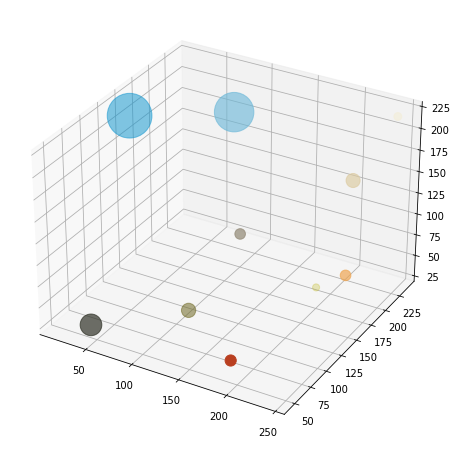

In [7]:
from PIL import Image
import numpy
import math
import matplotlib.pyplot as plot
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import scale, minmax_scale

cluster_count = 10

imgfile = Image.open("./images/Saint-Basil-Red-Square.jpg")
numarray = numpy.array(imgfile.getdata(), numpy.uint8)

# Calculer les clusters
clusters = MiniBatchKMeans(n_clusters=cluster_count, n_init=2)
clusters.fit(numarray)


# Calculer le nombre de pixels appartenant à chaque cluster
unique, frequency = numpy.unique(clusters.labels_, return_counts=True)

# Mise à l'échelle de la valeur de la fréquence entre 50 et 2000
# (ces valeurs ont été choisies au hasard)
scaled_frequency = minmax_scale(frequency, feature_range=(50, 2000))

colors = []
for i in range(len(clusters.cluster_centers_)):
    colors.append(
        "#%02x%02x%02x"
        % (
            math.ceil(clusters.cluster_centers_[i][0]),
            math.ceil(clusters.cluster_centers_[i][1]),
            math.ceil(clusters.cluster_centers_[i][2]),
        )
    )

# Diagramme de dispersion 3D
plot.figure(figsize=(8, 8))
axes = plot.axes(projection="3d")
axes.scatter3D(
    clusters.cluster_centers_[:, 0],
    clusters.cluster_centers_[:, 1],
    clusters.cluster_centers_[:, 2],
    c=colors,
    s=scaled_frequency,
)

Diagramme de dispersion 3D:
Les centres de cluster sont affichés dans les axes x, y et z du diagramme, la couleur de chaque point représente la couleur moyenne des pixels dans le cluster, et la taille de chaque point représente le nombre de pixels dans le cluster.

In [80]:
def count_key_value(json_file, key, value):
    with open(json_file, 'r', encoding='utf-8') as f:
    data = json.load(f)
    counter = 0
    for obj in data:
        if key in obj:
            if obj[key] == value:
                counter += 1
             image_size[image["size"]] = 0        
        image_size[image["size"]] += 1
        
    return f"Pour {key} il y'a {counter} image(s) qui ont la valeur {value}"

# Demander à l'utilisateur de saisir les ID des images qu'il a aimé
ids_entries = input("Veuillez entrer les ID des images que vous avez aimé, séparés par des virgules: ")

# Convertir la chaîne de caractères en une liste d'ID
ids_list = ids_entries.split(',')
ids_list = [int(id.strip()) for id in ids_list]
image_liked = []
image_colors={}
image_size={}
image_orientation={}
json_file = './data/data.json'

with open(json_file, 'r', encoding='utf-8') as f:
    data = json.load(f)
    for id in ids_list:
        if len(data) >= id and isinstance(id, (int)):
            image_liked.append(data[id-1])
        else : 
            print("L'ID de cette image n'existe pas ou ce n'est pas un chiffre :", id)
for image in image_liked:
    for color in image["colors"]:
        if color not in image_colors:
            image_colors[color] = 0        
        image_colors[color] += 1
    if "size" in image:
        if image["size"] not in image_size:
            image_size[image["size"]] = 0        
        image_size[image["size"]] += 1
    if "orientation" in image:
        if image["orientation"] not in image_orientation:
            image_orientation[image["orientation"]] = 0        
        image_orientation[image["orientation"]] += 1
     
         
print(image_colors)
print(image_orientation)
print(image_size)
print(count_key_value(json_file, "size"))
print(count_key_value(json_file, "orientation", "landscape"))
print(count_key_value(json_file, "year", "2006"))


Veuillez entrer les ID des images que vous avez aimé, séparés par des virgules:  1,2,3


{'darkgray': 2, 'lightslategray': 1, 'gray': 3, 'lightgray': 2, 'darkslategray': 3, 'dimgray': 3, 'gainsboro': 1, 'black': 3, 'darkkhaki': 1, 'silver': 2, 'wheat': 1, 'cornflowerblue': 1, 'royalblue': 1, 'cadetblue': 1, 'lavender': 1}
{'landscape': 3}
{'Grande image': 3}
Pour size il y'a 4 image(s) qui ont la valeur Grande image
Pour orientation il y'a 4 image(s) qui ont la valeur landscape
Pour year il y'a 3 image(s) qui ont la valeur 2006
